### Mindspore手写数字识别

在下面的样例中，我们配置样例运行使用图模式，并且根据实际情况来配置硬件信息。

In [20]:
import os
import argparse
from mindspore import context

parser=argparse.ArgumentParser(description="Mindspore LeNet Example")
parser.add_argument('--device_target',type=str,default="CPU",choices=['Ascend','GPU','CPU'])
args=parser.parse_known_args()[0]
context.set_context(mode=context.GRAPH_MODE,device_target=args.device_target)

以MNIST手写数字数据集识别为例来体验Mindspore，首先先利用mindvision模块来下载dataset

In [21]:
from mindvision.dataset import Mnist

# 下载并处理MNIST数据集
download_train = Mnist(path="./mnist", split="train", batch_size=32, repeat_num=1, shuffle=True, resize=32, download=True)

download_eval = Mnist(path="./mnist", split="test", batch_size=32, resize=32, download=True)

dataset_train = download_train.run()  # .run()函数进行下载
dataset_eval = download_eval.run()

[WARNING] ME(15852:20380,MainProcess):2022-08-01-15:00:59.159.883 [mindspore\dataset\engine\datasets_user_defined.py:656] Python multiprocessing is not supported on Windows platform.
[WARNING] ME(15852:20380,MainProcess):2022-08-01-15:00:59.550.953 [mindspore\dataset\engine\datasets_user_defined.py:656] Python multiprocessing is not supported on Windows platform.
[WARNING] ME(15852:20380,MainProcess):2022-08-01-15:00:59.551.453 [mindspore\dataset\core\validator_helpers.py:799] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(15852:20380,MainProcess):2022-08-01-15:00:59.552.453 [mindspore\dataset\core\validator_helpers.py:799] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(15852:20380,MainProcess):2022-08-01

参数说明：

* path:数据集存储路径

* split:数据集类型，支持train、test、infer，默认为train

* batch_size:每个训练批次设定的数据大小，默认为32

* repeat_num:训练时便利数据集的次数，默认为1.

* shuffle:是否需要将数据集随机打乱(可选参数)

* resize:输出图像的大小，默认为32*32

* download:是否需要下载数据集，默认为False。如果为下载的话成True即可

从mindvision上下载下来的数据集结构如下:
```
./mnist/
├── test
│   ├── t10k-images-idx3-ubyte
│   └── t10k-labels-idx1-ubyte
└── train
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte
```


Mindspore中的数据需要用迭代器来取出进行可视化，常用的迭代器有：

* create_dict_iterator()——即以字典的形式取出数据

* create_tuple_iterator()——即以列表的形式取出数据

In [22]:
data1=next(dataset_train.create_dict_iterator())
data2=next(dataset_train.create_tuple_iterator())
# print(data1) 
# print(data2)
print(data1['image'].shape)
print(data1['label'].shape)
print(dataset_train)

(32, 1, 32, 32)
(32,)


### 搭建模型

手写体识别利用是简单的Lenet5网络模型

> 按照LeNet的网络结构，LeNet除去输入层共有7层，其中有2个卷积层，2个子采样层，3个全连接层。

In [23]:
import mindspore.nn as nn

class LeNet5(nn.Cell):
    def __init__(self,num_class=10,num_channel=1):
        super(LeNet5,self).__init__()
        # 卷积层1，通道：1-6 卷积核大小：5*5 
        self.conv1=nn.Conv2d(num_channel,6,5,pad_mode='valid')
        # 卷积层2，通道：6-16 卷积核大小：5*5 
        self.conv2=nn.Conv2d(6,16,5,pad_mode='valid')
        # 三个全连接层Dense
        self.fc1=nn.Dense(16*5*5,120)
        self.fc2=nn.Dense(120,84)
        self.fc3=nn.Dense(84,num_class)
        self.relu=nn.ReLU()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2,stride=2)
        self.flatten=nn.Flatten()
    
    def construct(self,x):
        # 构建前向网络
        x=self.conv1(x) # C:1-6 N:32-5+1=28
        x=self.relu(x)
        x=self.max_pool2d(x) # C:6-6 N:28/2=14
        x=self.conv2(x) # C:6-16 N: 14-5+1=10
        x = self.relu(x)
        x = self.max_pool2d(x) # C:16-16 n:10/2=5
        x = self.flatten(x) # 16,5,5->16*5*5
        x = self.fc1(x) # 16*5*5->120
        x = self.relu(x)
        x = self.fc2(x) # 120->84
        x = self.relu(x)
        x = self.fc3(x) # 84->10
        return x
model=LeNet5()
print(model)

LeNet5<
  (conv1): Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=normal, bias_init=zeros, format=NCHW>
  (conv2): Conv2d<input_channels=6, output_channels=16, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=normal, bias_init=zeros, format=NCHW>
  (fc1): Dense<input_channels=400, output_channels=120, has_bias=True>
  (fc2): Dense<input_channels=120, output_channels=84, has_bias=True>
  (fc3): Dense<input_channels=84, output_channels=10, has_bias=True>
  (relu): ReLU<>
  (max_pool2d): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (flatten): Flatten<>
  >


一些注释：  
* 卷积层输出图像尺寸：$$N=\frac{W-F+2P}{S}+1$$

* 池化层输出图像尺寸：$$N=\frac{W+2P-D(F-1)-1}{S}+1$$
    
* pad_mode='valid' 即without padding padding为0，超出的部分丢弃数据

* pad_mode='same' 即补全模式，尝试在左边和右边补0

#### 模型参数

网络内部的卷积层和全连接层实例化之后，即具有权重参数和偏置参数，这些参数会在训练过程中不断进行优化，在训练过程中可以通过``get_parameters()`` 来查看网络各层的名字、形状、数据类型和是否反向计算等信息

In [24]:
for m in model.get_parameters():
    print(f"layer:{m.name},shape:{m.shape},dtype:{m.dtype},requeires_grad:{m.requires_grad}")
    

layer:conv1.weight,shape:(6, 1, 5, 5),dtype:Float32,requeires_grad:True
layer:conv2.weight,shape:(16, 6, 5, 5),dtype:Float32,requeires_grad:True
layer:fc1.weight,shape:(120, 400),dtype:Float32,requeires_grad:True
layer:fc1.bias,shape:(120,),dtype:Float32,requeires_grad:True
layer:fc2.weight,shape:(84, 120),dtype:Float32,requeires_grad:True
layer:fc2.bias,shape:(84,),dtype:Float32,requeires_grad:True
layer:fc3.weight,shape:(10, 84),dtype:Float32,requeires_grad:True
layer:fc3.bias,shape:(10,),dtype:Float32,requeires_grad:True


### 训练

在处理完数据和部署完模型之后，很自然的就进入到了训练部分，首先review一些概念

#### 超参(Hyper-parametric)

超参是可以调整的参数，可以控制模型训练优化的过程。目前深度学习模型多采用批量随机梯度下降进行优化，随机梯度下降法的原理如下：

$$w_{t+1}=w_{t}-\eta\frac{1}{n}\sum_{x\in\mathcal{B}}\nabla l(x,w_{t})$$

式中，

* $n$是批量大大小(batch size)

* $\eta$是学习率(learing rate)

* $w_{t}$是训练轮次t中权重参数

* $\nabla l$为损失函数的导数

这里简单说一下超参数batch size大小对模型的影响，数据集分批读取训练，设定每个批次数据的大小。batch size过小，花费时间多，同时梯度震荡严重，不利于收敛；batch size过大，** 不同batch的梯度方向没有任何变换，容易陷入局部极小值**，因此需要选择合适的batch size，可以有效提高模型精度、全局收敛

In [25]:
epochs=10
batch_size=32
momentum=0.9
learning_rate=1e-2

### 损失函数

**损失函数**用来评价模型的预测值和目标值之间的误差，在这里，使用绝对误差损失函数``L1Loss``:

$$L1 Loss Function=\sum{n}{i=1}|y_{true}-y_{predicted}|$$

mindspore.nn.loss里也提供了许多其他常用的损失函数，例如``SoftmaxCrossEntropyWithLogits``、``MSELoss``、``SmoothL1Loss``等


In [26]:
import numpy as np
import mindspore.nn as nn
import mindspore as ms

loss = nn.L1Loss()
output_data = ms.Tensor(np.array([[1, 2, 3], [2, 3, 4]]).astype(np.float32))
target_data = ms.Tensor(np.array([[0, 2, 5], [3, 1, 1]]).astype(np.float32))

print(loss(output_data, target_data))

1.5


### 优化器函数

优化器函数用于计算和更新梯度，模型优化算法的选择直接关系到最终模型的性能。有时候最终模型效果不好，未必是特征或者模型设计的问题，很有可能是优化算法的问题。

MindSpore所有优化逻辑都封装在Optimizer对象中，在这里，我们使用Momentum优化器。mindspore.nn也提供了许多其他常用的优化器函数，如Adam、SGD、RMSProp等。

我们需要构建一个Optimizer对象，这个对象能够基于计算得到的梯度对参数进行更新。为了构建一个Optimizer，需要给它一个包含可优化的参数，如网络中所有可以训练的parameter，即设置优化器的入参为net.trainable_params()。

然后，设置Optimizer的参数选项，比如学习率、权重衰减等。代码样例如下

In [27]:
from mindspore import nn
from mindvision.classification.models import lenet

net = lenet(num_classes=10, pretrained=False)
optim = nn.Momentum(net.trainable_params(), learning_rate, momentum) # 设置优化器，传入可训练参数

## 模型训练

模型训练一般分为四个步骤：

* 1.构建数据集

* 2.定义神经网络

* 3.定义超参、损失函数以及优化器

* 4.输入训练伦茨和数据集进行训练

示例代码如下：

（在之前，我们已经构建了数据集dataset_train、model）

In [28]:
# 定义损失函数
from mindvision.engine.callback import LossMonitor

download_train = Mnist(path="./mnist", split="train", batch_size=batch_size, repeat_num=1, shuffle=True, resize=32, download=True)
dataset_train = download_train.run()

net_loss=nn.SoftmaxCrossEntropyWithLogits(sparse=True,reduction='mean')
# 定义优化器
net_opt=nn.Momentum(net.trainable_params(),learning_rate=learning_rate,momentum=momentum)
# 初始化模型参数
model1=ms.Model(net,loss_fn=net_loss,optimizer=net_opt,metrics={'acc'})
# 开始训练
model1.train(epochs,dataset_train,callbacks=[LossMonitor(learning_rate,1875)])

[WARNING] ME(15852:20380,MainProcess):2022-08-01-15:01:02.455.966 [mindspore\dataset\engine\datasets_user_defined.py:656] Python multiprocessing is not supported on Windows platform.
[WARNING] ME(15852:20380,MainProcess):2022-08-01-15:01:02.456.466 [mindspore\dataset\core\validator_helpers.py:799] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(15852:20380,MainProcess):2022-08-01-15:01:02.456.966 [mindspore\dataset\core\validator_helpers.py:799] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(15852:20380,MainProcess):2022-08-01-15:01:02.457.466 [mindspore\dataset\core\validator_helpers.py:799] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future

Epoch:[  0/ 10], step:[ 1875/ 1875], loss:[0.173/1.216], time:5.001 ms, lr:0.01000
Epoch time: 19722.481 ms, per step time: 10.519 ms, avg loss: 1.216
Epoch:[  1/ 10], step:[ 1875/ 1875], loss:[0.182/0.078], time:5.001 ms, lr:0.01000
Epoch time: 19169.885 ms, per step time: 10.224 ms, avg loss: 0.078
Epoch:[  2/ 10], step:[ 1875/ 1875], loss:[0.320/0.050], time:11.502 ms, lr:0.01000
Epoch time: 17112.521 ms, per step time: 9.127 ms, avg loss: 0.050
Epoch:[  3/ 10], step:[ 1875/ 1875], loss:[0.017/0.039], time:13.002 ms, lr:0.01000
Epoch time: 21032.213 ms, per step time: 11.217 ms, avg loss: 0.039
Epoch:[  4/ 10], step:[ 1875/ 1875], loss:[0.000/0.031], time:3.000 ms, lr:0.01000
Epoch time: 21194.743 ms, per step time: 11.304 ms, avg loss: 0.031
Epoch:[  5/ 10], step:[ 1875/ 1875], loss:[0.069/0.025], time:13.502 ms, lr:0.01000
Epoch time: 17536.097 ms, per step time: 9.353 ms, avg loss: 0.025
Epoch:[  6/ 10], step:[ 1875/ 1875], loss:[0.004/0.020], time:17.502 ms, lr:0.01000
Epoch tim

训练完毕，让我们看看训练完毕的参数分布与形式

In [29]:
for m in model.get_parameters():
    print(f"layer:{m.name},shape:{m.shape},dtype:{m.dtype},requeires_grad:{m.requires_grad}")
    print(f"value:{m.assign_value}")

layer:conv1.weight,shape:(6, 1, 5, 5),dtype:Float32,requeires_grad:True
value:<bound method Tensor.assign_value of Parameter (name=conv1.weight, shape=(6, 1, 5, 5), dtype=Float32, requires_grad=True)>
layer:conv2.weight,shape:(16, 6, 5, 5),dtype:Float32,requeires_grad:True
value:<bound method Tensor.assign_value of Parameter (name=conv2.weight, shape=(16, 6, 5, 5), dtype=Float32, requires_grad=True)>
layer:fc1.weight,shape:(120, 400),dtype:Float32,requeires_grad:True
value:<bound method Tensor.assign_value of Parameter (name=fc1.weight, shape=(120, 400), dtype=Float32, requires_grad=True)>
layer:fc1.bias,shape:(120,),dtype:Float32,requeires_grad:True
value:<bound method Tensor.assign_value of Parameter (name=fc1.bias, shape=(120,), dtype=Float32, requires_grad=True)>
layer:fc2.weight,shape:(84, 120),dtype:Float32,requeires_grad:True
value:<bound method Tensor.assign_value of Parameter (name=fc2.weight, shape=(84, 120), dtype=Float32, requires_grad=True)>
layer:fc2.bias,shape:(84,),dtyp

## 保存训练完成的模型

使用MindSpore提供的save_checkpoint保存模型，传入网络和保存路径：

In [30]:
ms.save_checkpoint(net,"MyNet.ckpt")

## 利用已训练完成模型进行推理

[WARNING] ME(15852:20380,MainProcess):2022-08-01-16:19:58.822.857 [mindspore\train\serialization.py:734] For 'load_param_into_net', remove parameter prefix name: backbone., continue to load.
[WARNING] ME(15852:20380,MainProcess):2022-08-01-16:19:59.215.427 [mindspore\dataset\engine\datasets_user_defined.py:656] Python multiprocessing is not supported on Windows platform.
[WARNING] ME(15852:20380,MainProcess):2022-08-01-16:19:59.216.427 [mindspore\dataset\core\validator_helpers.py:799] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(15852:20380,MainProcess):2022-08-01-16:19:59.216.427 [mindspore\dataset\core\validator_helpers.py:799] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(15852:20380,MainProcess):20

[4 8 9 4 3 2 9 2 4 5 4 1 4 0 5 1 6 4 8 9 5 0 6 8 8 3 9 8 2 8 6 7]


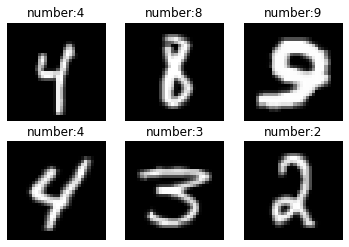

In [58]:
import mindspore as ms
import matplotlib.pyplot as plt


# 读取参数文件
param_dict=ms.load_checkpoint("MyNet.ckpt")
# 创建新的网络模型
infernet=LeNet5()
# 将参数存入网络模型
ms.load_param_into_net(infernet,param_dict)

download_eval = Mnist(path="./mnist", split="test", batch_size=32, resize=32, download=True)
dataset_eval = download_eval.run()

img1=next(dataset_eval.create_dict_iterator())
ans=infernet.construct(img1['image'])
tt=np.argmax(ans,axis=1)
print(tt)

images=img1['image'].asnumpy()   # 利用asnumpy函数将其转成numpy类型
plt.figure()

for i in range(1,7):
    plt.subplot(2,3,i)
    plt.axis('off')
    plt.title(f'number:{tt[i-1]}')
    plt.imshow(images[i-1][0],cmap="gray")

plt.show()

